# Project: Detect raccoon using yolov3

*Welcome to Machine Learning 2021 Course!*

*This is the tutorial that let's you train a custom image detector using the YOLOv3 computer vision algorithm.*

*This tutorial makes use of https://github.com/ntqq/yolov3_ml2021/ repo which itself is inspired by https://github.com/AntonMu/TrainYourOwnYOLO repo.*

*The raccoon dataset used in this tutorial belongs to https://github.com/datitran/raccoon_dataset repo.*










# Part 1: Download project materials.

In [ ]:
! git clone https://github.com/ntqq/yolov3_ml2021/
!mv yolov3_ml2021/* './'

Cloning into 'yolov3_ml2021'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 321 (delta 55), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (321/321), 12.47 MiB | 21.91 MiB/s, done.
Resolving deltas: 100% (55/55), done.


# Part 2: Download yolov3 weights and convert it to tensorflow keras .h5 format.

In [ ]:
#download yolov3.weights
!wget wget https://pjreddie.com/media/files/yolov3.weights

--2021-11-15 06:48:43--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2021-11-15 06:48:44--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  64.3MB/s    in 3.9s    

2021-11-15 06:48:48 (59.9 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

FINISHED --2021-11-15 06:48:48--
Total wall clock time: 4.4s
Downloaded: 1 files, 237M in 3.9s (59.9 MB/s)


In [ ]:
#convert yolov3.weights to yolov3.h5
# Usage: %run keras_yolo3/convert.py config_path weights_path output_path
%run keras_yolo3/convert.py keras_yolo3/yolov3.cfg yolov3.weights yolov3.h5

Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
Parsing section convolutional_1
conv2d bn leaky (3, 3, 32, 64)
Parsing section convolutional_2
conv2d bn leaky (1, 1, 64, 32)
Parsing section convolutional_3
conv2d bn leaky (3, 3, 32, 64)
Parsing section shortcut_0
Parsing section convolutional_4
conv2d bn leaky (3, 3, 64, 128)
Parsing section convolutional_5
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_6
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_1
Parsing section convolutional_7
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_8
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_2
Parsing section convolutional_9
conv2d bn leaky (3, 3, 128, 256)
Parsing section convolutional_10
conv2d bn leaky (1, 1, 256, 128)
Parsing section convolutional_11
conv2d bn leaky (3, 3, 128, 256)
Parsing section shortcut_3
Parsi

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved Keras model to yolov3.h5
Read 62001757 of 62001757 from Darknet weights.


# Part 3: Download and preprocess experimental dataset

Download dataset

In [ ]:
import os
# Download dataset
! git clone https://github.com/datitran/raccoon_dataset

# move /images/ dir inside raccoon_dataset dir to working dir
if not os.path.isdir('./images/'):
  os.makedirs('./images/')
!mv raccoon_dataset/images/* './images/'   

# move /annotations/ dir inside raccoon_dataset dir to working dir
if not os.path.isdir('./annotations/'):
  os.makedirs('./annotations/')
!mv raccoon_dataset/annotations/* './annotations/'  

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 652, done.
remote: Total 652 (delta 0), reused 0 (delta 0), pack-reused 652
Receiving objects: 100% (652/652), 48.01 MiB | 30.25 MiB/s, done.
Resolving deltas: 100% (415/415), done.


Convert annotations in VOC format to Yolo format


In [ ]:
# Usage: %run xml_to_yolo.py VOC_xml_folder_path Image_folder_path YOLO_txt_filename

# Positional arguments:
# VOC_xml_folder_path: path to the VOC format annotation folder. Default is: ./annotations/
# Image_folder_path: path to the image folder. Default is: ./images/
# YOLO_txt_filename: path to the file where the annotations in YOLO format should be saved. Default is: yolo_label.txt

# optional arguments:
# -h, --help show this help message and exit

# convert VOC annotation in ./annotations/ directory into a yolo_format.txt file
# all images are in ./images/ directory
# this also create data_classes.txt file that contain all class names

%run xml_to_yolo.py ./annotations/ ./images/ yolo_format.txt

# Part 4: Import libraries and pre-defined functions; download experimental dataset

In [ ]:
import os
import sys
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True   # this will solve truncated image error

from tensorflow.keras.callbacks import (
    TensorBoard,
    ModelCheckpoint,
    ReduceLROnPlateau,
    EarlyStopping,
)
from keras_yolo3.yolo3.model import (
    preprocess_true_boxes,
    yolo_body,
    tiny_yolo_body,
    yolo_loss,
)
from keras_yolo3.yolo3.utils import get_random_data
from PIL import Image
from time import time
import tensorflow.compat.v1 as tf
import pickle

from Train_Utils import(
    get_classes,
    get_anchors,
    create_model,
    create_tiny_model,
    data_generator,
    data_generator_wrapper,
    ChangeToOtherMachine,
)

# Part 5: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 6: Define variables and callbacks



Variables

In [ ]:
train_data_filename   = './yolo_format.txt'                     #YOLO format data to train model
classes_path          = './data_classes.txt'                    #Class name file path 
log_dir               = '/content/drive/MyDrive/Colab Notebooks/log_dir/'   #where to store log files on google drive
if not os.path.isdir(log_dir):                                  #Create directory for log files              
  os.makedirs(log_dir)

anchors_path          = './keras_yolo3/model_data/yolo_anchors.txt'         #path to anchor file
weights_path          = './yolov3.h5'                                       #path to .h5 weight file

class_names     = get_classes(classes_path)                   #read class name
num_classes     = len(class_names)
anchors         = get_anchors(anchors_path)                   #read anchor values
input_shape     = (416, 416)                                  #multiple of 32, height, width
epoch1, epoch2  = 50, 100

Callbacks

In [ ]:
log_dir_time = os.path.join(log_dir, "{}".format(int(time())))      
logging = TensorBoard(log_dir=log_dir_time)
#checkpoint
checkpoint = ModelCheckpoint(                                       
    os.path.join(log_dir,"checkpoint.h5"),
    monitor="val_loss",
    save_weights_only=True,
    save_best_only=True,
    # save_freq=5,
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)
#early_stopping
early_stopping = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1
)

# Part 7: Finetune yolov3 model

Split training data to train and validation set

In [ ]:
val_split = 0.1
with open(train_data_filename) as f:
    lines = f.readlines()

np.random.seed(43)
np.random.shuffle(lines)
# use 5 images for testing model
reserve_for_testing = lines[:5]
print('Test image paths:')
for test_image in reserve_for_testing:
  print(test_image.split(' ')[0])

lines = lines[5:] #new lines after removing 5 test images
num_val = int(len(lines) * val_split)   # number of val images
num_train = len(lines) - num_val        # number of train images
# we use first 'num_train' images for train set: lines[:num_train] 
# and the remaining images for val set: lines[num_train:]

Test image paths:
./images/raccoon-72.jpg
./images/raccoon-6.jpg
./images/raccoon-108.jpg
./images/raccoon-10.jpg
./images/raccoon-88.jpg


Create model

In [ ]:
model = create_model(
    input_shape, anchors, num_classes, freeze_body=2, weights_path=weights_path
)  
#make sure you know what you freeze
#freeze_body not in [1,2]: no freeze
#freeze_body=1: freeze darknet53 body 
#freeze_body=2: freeze all but 3 output layers

Create YOLOv3 model with 9 anchors and 1 classes.
Load weights ./yolov3.h5.
Freeze the first 249 layers of total 252 layers.


### Stage 1

*Train with frozen layers first, to get a stable loss*

*Adjust num epochs to your dataset. This step is enough to obtain a decent model*

Compile model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss={
        # use custom yolo_loss Lambda layer.
        "yolo_loss": lambda y_true, y_pred: y_pred
    },
)

Train model

In [ ]:
batch_size = 32
print(
    "Train on {} samples, val on {} samples, with batch size {}.".format(
        num_train, num_val, batch_size
    )
)

frozen_callbacks = [logging, checkpoint]

history = model.fit(
    data_generator_wrapper(
        lines[:num_train], batch_size, input_shape, anchors, num_classes),
    steps_per_epoch=max(1, num_train // batch_size),
    validation_data=data_generator_wrapper(
        lines[num_train:], batch_size, input_shape, anchors, num_classes),
    validation_steps=max(1, num_val // batch_size),
    epochs=epoch1,
    initial_epoch=0,
    callbacks=frozen_callbacks,
)
model.save_weights(log_dir + "trained_weights_stage_1.h5")

Train on 176 samples, val on 19 samples, with batch size 32.


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
5/5 [==============================] - 65s 6s/step - loss: 8966.9512 - val_loss: 6652.4844
Epoch 2/50
5/5 [==============================] - 20s 5s/step - loss: 5509.8779 - val_loss: 3962.3411
Epoch 3/50
5/5 [==============================] - 20s 5s/step - loss: 3062.7507 - val_loss: 2186.0615
Epoch 4/50
5/5 [==============================] - 20s 5s/step - loss: 1880.4167 - val_loss: 1417.7577
Epoch 5/50
5/5 [==============================] - 20s 5s/step - loss: 1129.0779 - val_loss: 909.3942
Epoch 6/50
5/5 [==============================] - 20s 5s/step - loss: 765.0394 - val_loss: 612.9050
Epoch 7/50
5/5 [==============================] - 20s 5s/step - loss: 550.0890 - val_loss: 458.3479
Epoch 8/50
5/5 [==============================] - 21s 5s/step - loss: 426.7649 - val_loss: 376.1943
Epoch 9/50
5/5 [==============================] - 20s 5s/step - loss: 351.9957 - val_loss: 319.8664
Epoch 10/50
5/5 [==============================] - 20s 5s/step - loss: 302.6921 - val_loss:

## Stage 2

*Unfreeze and continue training, to fine-tune.*

*Train longer if the result is unsatisfactory.*

In [ ]:
full_callbacks = [logging, checkpoint, reduce_lr, early_stopping]

for i in range(len(model.layers)):
    model.layers[i].trainable = True
    
model.compile(
    optimizer=Adam(learning_rate=1e-4), loss={"yolo_loss": lambda y_true, y_pred: y_pred}
)  # recompile to apply the change

print("Unfreeze all layers.")

batch_size = 4  # note that more GPU memory is required after unfreezing the body
print(
    "Train on {} samples, val on {} samples, with batch size {}.".format(
        num_train, num_val, batch_size
    )
)
history = model.fit(
    data_generator_wrapper(
        lines[:num_train], batch_size, input_shape, anchors, num_classes
    ),
    steps_per_epoch=max(1, num_train // batch_size),
    validation_data=data_generator_wrapper(
        lines[num_train:], batch_size, input_shape, anchors, num_classes
    ),
    validation_steps=max(1, num_val // batch_size),
    epochs=epoch1 + epoch2,
    initial_epoch=epoch1,
    callbacks=full_callbacks,
)
model.save_weights(log_dir + "trained_weights_final.h5")

Unfreeze all layers.
Train on 176 samples, val on 19 samples, with batch size 4.


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 51/150
44/44 [==============================] - 63s 966ms/step - loss: 26.7798 - val_loss: 35.1626 - lr: 1.0000e-04
Epoch 52/150
44/44 [==============================] - 40s 903ms/step - loss: 18.3329 - val_loss: 20.6103 - lr: 1.0000e-04
Epoch 53/150
44/44 [==============================] - 39s 890ms/step - loss: 16.3939 - val_loss: 17.0706 - lr: 1.0000e-04
Epoch 54/150
44/44 [==============================] - 39s 888ms/step - loss: 15.6275 - val_loss: 16.0672 - lr: 1.0000e-04
Epoch 55/150
44/44 [==============================] - 39s 880ms/step - loss: 15.2815 - val_loss: 14.2820 - lr: 1.0000e-04
Epoch 56/150
44/44 [==============================] - 37s 843ms/step - loss: 14.8256 - val_loss: 15.8444 - lr: 1.0000e-04
Epoch 57/150
44/44 [==============================] - 37s 845ms/step - loss: 13.9700 - val_loss: 14.4443 - lr: 1.0000e-04
Epoch 58/150
44/44 [==============================] - ETA: 0s - loss: 14.3084
Epoch 00058: ReduceLROnPlateau reducing learning rate to 9.999999747

# Part 8: Test the model

In [ ]:
from keras_yolo3.yolo import YOLO
from PIL import Image
import matplotlib.pyplot as plt

anchors_path = './keras_yolo3/model_data/yolo_anchors.txt'
classes_path = './data_classes.txt'

log_dir      = '/content/drive/MyDrive/Colab Notebooks/log_dir/'

trained_model_path = log_dir + 'trained_weights_final.h5'
save_img_path = "./Save_detected_images/"

# define YOLO detector
yolo_model = YOLO(
    **{
        "model_path": trained_model_path,
        "anchors_path": anchors_path,
        "classes_path": classes_path,
        "score": 0.25,
        "iou": 0.45,
        "model_image_size": (416, 416),
    }
)

Instructions for updating:
Colocations handled automatically by placer.
/content/drive/MyDrive/Colab Notebooks/log_dir/trained_weights_final.h5 model, anchors, and classes loaded in 10.93sec.


In [ ]:
def detect_image(image_path, yolo_model, save_img = False, postfix=""):
    """
    Call YOLO logo detector on input image, optionally save resulting image.

    Args:
      yolo: keras-yolo3 initialized YOLO instance
      image_path: path to image file
      save_img: bool to save annotated image
      save_img_path: path to directory where to save image
    """
    
    if not os.path.exists(save_img_path):
        os.makedirs(save_img_path)

    print(image_path)

    try:
      image = Image.open(image_path)
      if image.mode != "RGB":
          image = image.convert("RGB")
      image_array = np.array(image)
    except:
        print("File Open Error! Try again!")
        return None, None


    prediction, new_image = yolo_model.detect_image(image)

    img_out = postfix.join(os.path.splitext(os.path.basename(image_path)))
    if save_img:
        new_image.save(os.path.join(save_img_path, img_out))
        
    imgplot = plt.imshow(new_image)

    plt.show()

./images/raccoon-72.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.86 (188, 160) (457, 397)
raccoon 0.90 (81, 49) (290, 317)
Time spent: 1.833sec


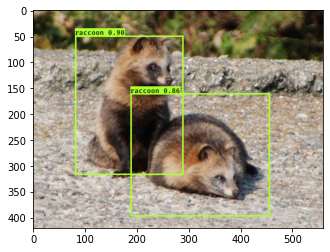

./images/raccoon-6.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (32, 48) (285, 307)
Time spent: 0.098sec


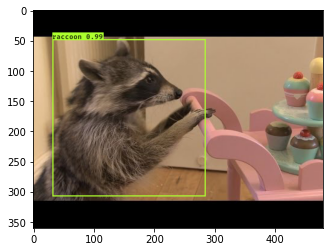

./images/raccoon-108.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (63, 13) (450, 481)
Time spent: 0.100sec


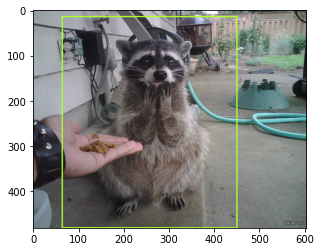

./images/raccoon-10.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (122, 1) (420, 481)
Time spent: 0.101sec


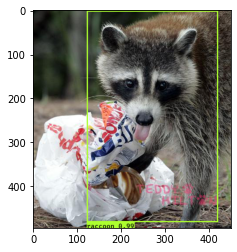

./images/raccoon-88.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (157, 23) (465, 452)
Time spent: 0.100sec


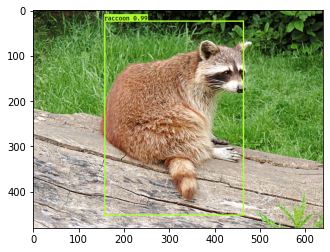

In [ ]:
for test_image in reserve_for_testing:
  test_image_path = test_image.split(' ')[0]
  detect_image(test_image_path, yolo_model)